In [34]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm, trange
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random
import logomaker

import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)
from source.alpha_beta_paired_clones_search import plot_cooccured_epitopes_table
from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble, \
                            plot_volcano, create_epitope_name
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column, prepare_clonotype_matrix
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence, \
                                    create_summary_stats_table, check_significant_epitopes_for_all_clusters, read_association_data
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')

In [2]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [3]:
um_beta = pd.read_csv('data/standardized_usage_matrix_fmba_TRB_v.csv').drop(columns=['Unnamed: 0'])

In [4]:
um_alpha = pd.read_csv('data/standardized_usage_matrix_fmba_TRA_v.csv').drop(columns=['Unnamed: 0'])

In [5]:
um_alpha

,run,project,covid,TRAV25,TRAV22,TRAV8-6,TRAV12-1,TRAV23DV6,TRAV34,TRAV24,...,TRAV10,TRAV4,TRAV30,TRAV36DV7,TRAV9-2,TRAV8-7,TRAV38-1,TRAV8-2,TRAV16,is_test_run
0,050002290808_S117_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.034580,0.007386,0.035094,0.020193,0.034198,0.006992,0.014441,...,0.015582,0.008641,0.008739,0.015403,0.027845,9.388818e-08,0.013693,0.011404,0.018486,False
1,050002630808_S113_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.007756,0.010688,0.031960,0.045913,0.022326,0.006622,0.007731,...,0.014030,0.013210,0.005481,0.016437,0.039805,9.476407e-08,0.002049,0.011904,0.015449,False
2,050003120808_S112_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.031519,0.007588,0.008670,0.015329,0.000924,0.008048,0.019866,...,0.012097,0.020422,0.006971,0.016630,0.051908,1.015446e-07,0.016875,0.010910,0.017584,False
3,050003130808_S114_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.032442,0.014822,0.023636,0.025560,0.020243,0.006228,0.013844,...,0.018731,0.016480,0.006318,0.016605,0.057254,9.971174e-08,0.004958,0.010880,0.023764,False
4,050003450808_S118_L002.clonotypes.TRA.txt,2020/09_FMBA_NovaSeq2_DNA,covid,0.029227,0.018550,0.017009,0.032554,0.036016,0.004463,0.015886,...,0.008191,0.013133,0.007600,0.015575,0.047376,9.439327e-08,0.019207,0.009621,0.023442,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,p18_72_DNA_S88_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.022219,0.019494,0.021428,0.049995,0.002439,0.005405,0.016207,...,0.011865,0.017337,0.005342,0.009265,0.070032,8.840376e-08,0.018956,0.013536,0.018417,False
1269,p18_73_DNA_S89_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.032089,0.019695,0.025329,0.049680,0.003760,0.004434,0.015811,...,0.011457,0.015376,0.005171,0.011067,0.051577,9.040503e-08,0.021368,0.003485,0.018169,False
1270,p18_74_DNA_S90_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.014704,0.024342,0.018804,0.023129,0.022389,0.007660,0.013431,...,0.026982,0.016394,0.006953,0.013791,0.029375,1.058087e-07,0.027750,0.005513,0.031534,False
1271,p18_75_DNA_S91_L002.clonotypes.TRA.txt,2021/01_FMBA_NovaSeq9,covid,0.002557,0.017365,0.013523,0.057518,0.024586,0.003807,0.012010,...,0.035550,0.019303,0.005730,0.008685,0.025011,9.168310e-08,0.019486,0.013192,0.026893,False


In [6]:
train_runs_beta = prepare_run_column(um_beta[~um_beta.is_test_run]).run
test_runs_beta = prepare_run_column(um_beta[um_beta.is_test_run]).run

In [7]:
train_runs_alpha = prepare_run_column(um_alpha[~um_alpha.is_test_run]).run
test_runs_alpha = prepare_run_column(um_alpha[um_alpha.is_test_run]).run

In [8]:
desc_alpha = pd.read_csv('data/preprocessed_fmba_metadata_alpha.csv').drop(columns=['Unnamed: 0'])
desc_alpha['run'] = desc_alpha.R1.apply(lambda x: x.replace('_R1_001.fastq.gz', '.clonotypes.TRA.txt'))
desc_alpha = desc_alpha.merge(um_alpha[['run', 'is_test_run']])
desc_alpha['covid'] = desc_alpha.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc_alpha

,sequencingDate,folder,R1,R2,name,COVID_status,projectName,COVID_IgG,COVID_IgM,COVID_PCR,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,run,is_test_run,covid
0,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002290808_S117_L002_R1_001.fastq.gz,050002290808_S117_L002_R2_001.fastq.gz,050002290808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002290,NaN,NaN,NaN,NaN,NaN,050002290808_S117_L002.clonotypes.TRA.txt,False,covid
1,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002630808_S113_L002_R1_001.fastq.gz,050002630808_S113_L002_R2_001.fastq.gz,050002630808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002630,NaN,NaN,NaN,NaN,NaN,050002630808_S113_L002.clonotypes.TRA.txt,False,covid
2,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003120808_S112_L002_R1_001.fastq.gz,050003120808_S112_L002_R2_001.fastq.gz,050003120808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*08:04,050003120,NaN,NaN,NaN,NaN,NaN,050003120808_S112_L002.clonotypes.TRA.txt,False,covid
3,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003130808_S114_L002_R1_001.fastq.gz,050003130808_S114_L002_R2_001.fastq.gz,050003130808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*15:01,050003130,NaN,NaN,NaN,NaN,NaN,050003130808_S114_L002.clonotypes.TRA.txt,False,covid
4,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003450808_S118_L002_R1_001.fastq.gz,050003450808_S118_L002_R2_001.fastq.gz,050003450808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*11:01,050003450,NaN,NaN,NaN,NaN,NaN,050003450808_S118_L002.clonotypes.TRA.txt,False,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2021 01 07,2021/01_FMBA_NovaSeq9,p18_72_DNA_S88_L002_R1_001.fastq.gz,p18_72_DNA_S88_L002_R2_001.fastq.gz,p18_72_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_72,NaN,NaN,NaN,NaN,NaN,p18_72_DNA_S88_L002.clonotypes.TRA.txt,False,covid
1269,2021 01 07,2021/01_FMBA_NovaSeq9,p18_73_DNA_S89_L002_R1_001.fastq.gz,p18_73_DNA_S89_L002_R2_001.fastq.gz,p18_73_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_73,NaN,NaN,NaN,NaN,NaN,p18_73_DNA_S89_L002.clonotypes.TRA.txt,False,covid
1270,2021 01 07,2021/01_FMBA_NovaSeq9,p18_74_DNA_S90_L002_R1_001.fastq.gz,p18_74_DNA_S90_L002_R2_001.fastq.gz,p18_74_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_74,NaN,NaN,NaN,NaN,NaN,p18_74_DNA_S90_L002.clonotypes.TRA.txt,False,covid
1271,2021 01 07,2021/01_FMBA_NovaSeq9,p18_75_DNA_S91_L002_R1_001.fastq.gz,p18_75_DNA_S91_L002_R2_001.fastq.gz,p18_75_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_75,NaN,NaN,NaN,NaN,NaN,p18_75_DNA_S91_L002.clonotypes.TRA.txt,False,covid


In [9]:
desc_beta = pd.read_csv('data/preprocessed_fmba_metadata_beta.csv').drop(columns=['Unnamed: 0'])
desc_beta['run'] = desc_beta.R1.apply(lambda x: x.replace('_R1_001.fastq.gz', '.clonotypes.TRB.txt'))
desc_beta = desc_beta.merge(um_beta[['run', 'is_test_run']])
desc_beta['covid'] = desc_beta.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc_beta

,sequencingDate,folder,R1,R2,name,COVID_status,projectName,COVID_IgG,COVID_IgM,COVID_PCR,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,run,is_test_run,covid
0,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002290808_S117_L002_R1_001.fastq.gz,050002290808_S117_L002_R2_001.fastq.gz,050002290808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002290,NaN,NaN,NaN,NaN,NaN,050002290808_S117_L002.clonotypes.TRB.txt,False,covid
1,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050002630808_S113_L002_R1_001.fastq.gz,050002630808_S113_L002_R2_001.fastq.gz,050002630808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*13:01,050002630,NaN,NaN,NaN,NaN,NaN,050002630808_S113_L002.clonotypes.TRB.txt,False,covid
2,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003120808_S112_L002_R1_001.fastq.gz,050003120808_S112_L002_R2_001.fastq.gz,050003120808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*08:04,050003120,NaN,NaN,NaN,NaN,NaN,050003120808_S112_L002.clonotypes.TRB.txt,False,covid
3,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003130808_S114_L002_R1_001.fastq.gz,050003130808_S114_L002_R2_001.fastq.gz,050003130808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*15:01,050003130,NaN,NaN,NaN,NaN,NaN,050003130808_S114_L002.clonotypes.TRB.txt,False,covid
4,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,050003450808_S118_L002_R1_001.fastq.gz,050003450808_S118_L002_R2_001.fastq.gz,050003450808,COVID,FMBA_DNA,yes,yes,negative,...,DRB1*11:01,050003450,NaN,NaN,NaN,NaN,NaN,050003450808_S118_L002.clonotypes.TRB.txt,False,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,2021 01 07,2021/01_FMBA_NovaSeq9,p18_72_DNA_S88_L002_R1_001.fastq.gz,p18_72_DNA_S88_L002_R2_001.fastq.gz,p18_72_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_72,NaN,NaN,NaN,NaN,NaN,p18_72_DNA_S88_L002.clonotypes.TRB.txt,False,covid
1221,2021 01 07,2021/01_FMBA_NovaSeq9,p18_73_DNA_S89_L002_R1_001.fastq.gz,p18_73_DNA_S89_L002_R2_001.fastq.gz,p18_73_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,DRB1*15,p18_73,NaN,NaN,NaN,NaN,NaN,p18_73_DNA_S89_L002.clonotypes.TRB.txt,False,covid
1222,2021 01 07,2021/01_FMBA_NovaSeq9,p18_74_DNA_S90_L002_R1_001.fastq.gz,p18_74_DNA_S90_L002_R2_001.fastq.gz,p18_74_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_74,NaN,NaN,NaN,NaN,NaN,p18_74_DNA_S90_L002.clonotypes.TRB.txt,False,covid
1223,2021 01 07,2021/01_FMBA_NovaSeq9,p18_75_DNA_S91_L002_R1_001.fastq.gz,p18_75_DNA_S91_L002_R2_001.fastq.gz,p18_75_DNA,COVID,FMBA_DNA,NaN,NaN,NaN,...,NaN,p18_75,NaN,NaN,NaN,NaN,NaN,p18_75_DNA_S91_L002.clonotypes.TRB.txt,False,covid


# β chain biomarkers postprocessing

In [10]:
os.getcwd()

'/home/evlasova/tcr-covid-classifier'

In [11]:
raw_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_test.csv').drop(columns=['Unnamed: 0'])

In [12]:
raw_beta_cm

,CAGSLGGNQPQHF,CAISLGGNQPQHF,CARSLGGNQPQHF,CASALGGNQPQHF,CASAPGGSYEQYF,CASASGGNQPQHF,CASGLGGNQPQHF,CASGLGTSYEQYF,CASGLSGGNQPQHF,CASGPDRANYGYTF,...,CSATSGHEQYF,CSATTGYSNQPQHF,CSAVSSYEQYF,CSAWSSYEQYF,CSAYSSYEQYF,CTSSLGGNQPQHF,GASSLGGNQPQHF,RASSGTANTEAFF,RASSLGGNQPQHF,run
0,2,2,2,1,0,0,2,0,0,0,...,0,0,0,0,0,1,1,0,1,050002290808_S117_L002.clonotypes.TRB.txt
1,1,1,1,2,1,1,2,0,1,0,...,0,1,0,0,0,1,1,0,1,250002590808_S99_L002.clonotypes.TRB.txt
2,1,1,1,1,0,0,2,3,1,0,...,0,0,0,0,0,1,1,0,1,330000430808_S28_L001.clonotypes.TRB.txt
3,1,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,1,1,1,1,500003930808_S33_L001.clonotypes.TRB.txt
4,1,1,1,1,1,0,1,0,1,0,...,0,0,1,1,1,1,1,0,1,590002490808_S80_L001.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,2,2,2,2,1,0,2,0,0,0,...,0,1,0,0,0,2,2,0,2,p17_55-2_DNA_S13_L001.clonotypes.TRB.txt
1221,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,p17_84-2_DNA_S9_L001.clonotypes.TRB.txt
1222,1,1,1,2,2,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,p17_62_DNA_S74_L001.clonotypes.TRB.txt
1223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,p17_77-1_DNA_S4_L001.clonotypes.TRB.txt


In [13]:
clean_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks_wo_test.csv').drop(columns=['Unnamed: 0'])

In [14]:
clean_beta_cm

,run,CAISLGGNQPQHF,CASALGGNQPQHF,CASAPGGSYEQYF,CASASGGNQPQHF,CASGLGGNQPQHF,CASGLGTSYEQYF,CASGLSGGNQPQHF,CASGPDRANYGYTF,CASGQGGYEQYF,...,CSASPRYEQYF,CSASSGHEQYF,CSASSSYEQYF,CSATDREYEQYF,CSATDRGYEQYF,CSATSGHEQYF,CSATTGYSNQPQHF,CSAVSSYEQYF,CSAWSSYEQYF,CSAYSSYEQYF
0,500003930808_S33_L001,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,250002590808_S99_L002,1,2,1,1,2,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,050002290808_S117_L002,2,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,460000170808_S6_L001,0,0,0,0,0,2,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,590002490808_S80_L001,1,1,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,p17_77-1_DNA_S4_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1221,p17_2_DNA_S18_L001,1,1,1,0,2,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1222,p17_55-2_DNA_S13_L001,2,2,1,0,2,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1223,p17_62_DNA_S74_L001,1,2,2,1,1,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0


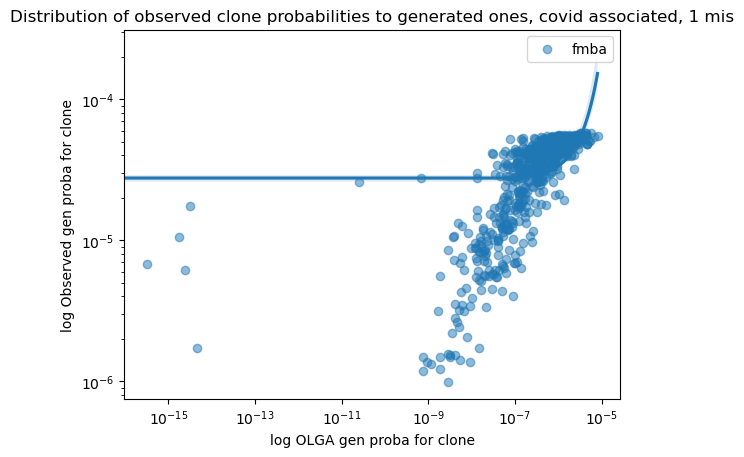

In [15]:
probas_beta = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRB_pgen_wo_test.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_test.csv'], 
                                    desc='covid associated, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv', 
                                    labels=['fmba'])['fmba']

In [16]:
covid_clones_beta = clean_beta_cm.columns[1:]
res_beta = seqs2hamming(covid_clones_beta, viz_method='graphopt')

In [17]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAISLGGNQPQHF,0,-168.285783,-634.203761,2,-177.540639,-629.266639
1,CATSLGGNQPQHF,0,-186.795494,-624.329518,2,-177.540639,-629.266639
2,CASALGGNQPQHF,1,57.466261,445.725956,5,80.428240,435.924593
3,CASASGGNQPQHF,1,80.630067,436.455026,5,80.428240,435.924593
4,CASGLGGNQPQHF,1,35.940312,453.469025,5,80.428240,435.924593
...,...,...,...,...,...,...,...
613,CSATDREYEQYF,91,633.869582,23.984487,4,618.282170,19.964324
614,CSATDRGYEQYF,91,614.653226,35.595720,4,618.282170,19.964324
615,CSASGGGYEQYF,92,-139.691984,492.422636,1,-139.691984,492.422636
616,CSASPRYEQYF,93,-29.602025,552.896995,1,-29.602025,552.896995


# α chain biomarkers postprocessing

In [18]:
clean_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks_wo_test.csv').drop(columns=['Unnamed: 0'])

In [19]:
raw_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_test.csv').drop(columns=['Unnamed: 0'])

In [20]:
clean_alpha_cm

,run,CAAADNFNKFYF,CAAAFNKFYF,CAAALYNFNKFYF,CAAANFNKFYF,CAAAPYNFNKFYF,CAAARYNFNKFYF,CAAASYNFNKFYF,CAAAYNFNKFYF,CAACLYNFNKFYF,...,CVVTTYNFNKFYF,CVVTVYNFNKFYF,CVVTYNFNKFYF,CVVVNFNKFYF,CVVVYNFNKFYF,CVVYLYNFNKFYF,CVVYNFNKFYF,CVYNFNKFYF,CYNFNKFYF,LYNFNKFYF
0,050002290808_S117_L002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,250002590808_S99_L002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,330000390808_S24_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,500003530808_S38_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,460000160808_S8_L001,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,p17_22_DNA_S38_L001,2,2,2,7,1,0,0,4,2,...,2,0,0,1,0,0,2,1,0,0
1269,p17_43_DNA_S58_L001,2,0,4,2,1,2,1,7,4,...,0,0,2,0,3,2,4,2,2,2
1270,p17_49-2_DNA_S14_L001,3,1,2,4,3,2,1,23,1,...,1,3,5,7,4,2,13,8,2,2
1271,p17_77-1_DNA_S4_L001,0,0,2,2,0,0,0,5,2,...,1,1,0,1,0,0,1,1,0,0


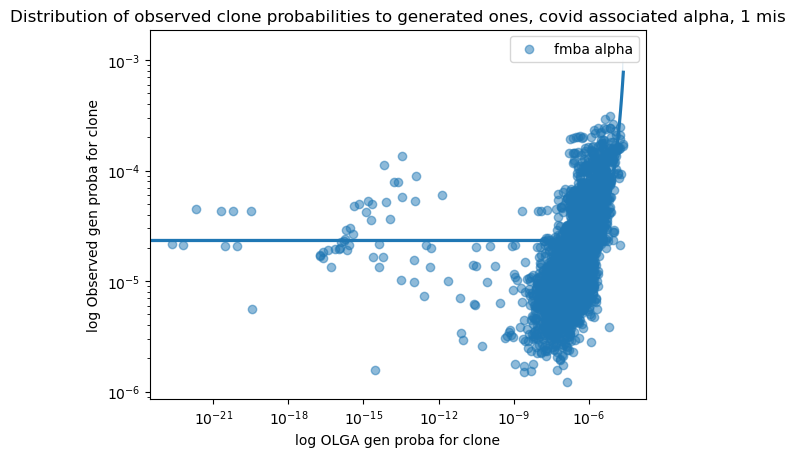

In [21]:
probas_alpha = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRA_pgen_wo_test.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_test.csv'], 
                                    desc='covid associated alpha, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv', 
                                    labels=['fmba alpha'],
                                    make_bool_features=False)['fmba alpha']

In [22]:
covid_clones_alpha = clean_alpha_cm.columns[1:]
res_alpha = seqs2hamming(covid_clones_alpha, viz_method='drl')

In [23]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,30.460405,94.157776,825,90.212157,68.734894
1,CAAAYNFNKFYF,0,77.574272,128.024475,825,90.212157,68.734894
2,CAAEDNFNKFYF,0,29.246904,97.148979,825,90.212157,68.734894
3,CAAGDNFNKFYF,0,30.821766,119.787628,825,90.212157,68.734894
4,CAAIDNFNKFYF,0,30.784718,94.123138,825,90.212157,68.734894
...,...,...,...,...,...,...,...
3401,CVVSEASGGYQKVTF,86,123.293297,328.911377,3,123.327522,329.126872
3402,CVVSEPSGGYQKVTF,86,123.552773,329.017914,3,123.327522,329.126872
3403,CVVSEWSGGYQKVTF,86,123.136497,329.451324,3,123.327522,329.126872
3404,CVVSGRAGNNRKLIW,87,195.704941,-297.748199,1,195.704941,-297.748199


In [24]:
all_alpha_cm = pd.read_csv('data/clone_matrix_fmba_TRA_top_500k.csv', nrows=50000)
all_alpha_cm = prepare_clonotype_matrix(clonotype_matrix=all_alpha_cm).merge(clean_alpha_cm)
fold_change_data_alpha = get_top_changed_clonotypes(clonotype_matrix=all_alpha_cm.merge(prepare_run_column(desc_alpha[~desc_alpha.folder.str.contains('NovaSeq6')][['run']])), 
                           desc=desc_alpha, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k_wo_test.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'),
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_alpha

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,AAAGNKLTF,9.715965e-01,0.002430,0.004954,2.038189,1.027288
1,AAGGTSYGKLTF,9.824176e-01,0.017989,0.045346,2.520827,1.333897
2,AAGNKLTF,6.196550e-01,0.000747,0.001818,2.435800,1.284396
3,AAGNMLTF,9.128884e-01,0.002821,0.006232,2.209055,1.143429
4,AAGNNRKLIW,9.470436e-02,0.000873,0.003516,4.026632,2.009574
...,...,...,...,...,...,...
53252,CVVYLYNFNKFYF,2.138498e-05,0.002289,0.008821,3.853952,1.946338
53253,CVVYNFNKFYF,2.248112e-17,0.006415,0.026346,4.106748,2.037997
53254,CVYNFNKFYF,1.183907e-08,0.002090,0.009689,4.636990,2.213189
53255,CYNFNKFYF,1.311410e-06,0.000752,0.004363,5.802565,2.536691


In [25]:
all_beta_cm = pd.read_csv('data/clone_matrix_fmba_TRB_top_500k.csv', nrows=50000)
all_beta_cm = prepare_clonotype_matrix(clonotype_matrix=all_beta_cm).merge(clean_beta_cm)
fold_change_data_beta = get_top_changed_clonotypes(clonotype_matrix=all_beta_cm.merge(prepare_run_column(desc_beta[~desc_beta.folder.str.contains('NovaSeq6')][['run']])), 
                           desc=desc_beta, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k_wo_test.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'),
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_beta

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CAAAAGSSYNEQFF,1.324549e-01,0.000000,0.000199,inf,inf
1,CAAADYGYTF,1.171164e-01,0.000160,0.000539,3.377711,1.756046
2,CAAAGANVLTF,3.620669e-02,0.000129,0.000833,6.470137,2.693796
3,CAAAGDGNTIYF,6.762434e-01,0.000040,0.000071,1.751708,0.808762
4,CAAAGGDTQYF,6.296537e-01,0.000182,0.000306,1.680820,0.749165
...,...,...,...,...,...,...
50604,CSATSGHEQYF,2.712882e-09,0.000071,0.002910,40.907410,5.354290
50605,CSATTGYSNQPQHF,1.668126e-05,0.000333,0.002975,8.938504,3.160033
50606,CSAVSSYEQYF,3.080068e-06,0.000536,0.003804,7.100775,2.827977
50607,CSAWSSYEQYF,2.936019e-07,0.000417,0.003483,8.362462,3.063928


# Cluster to Epitope labeling

In [26]:
import os
import utils
path = 'data/fmba_associations_wo_test'
if not os.path.isdir(path):
    os.mkdir(path)

In [27]:
alpha_cluster_to_epi = read_association_data('figures/associations/fmba_wo_test_TRA_sign_assoc_with_max_enrichment.csv')

In [30]:
beta_cluster_to_epi = read_association_data('figures/associations/fmba_wo_test_TRB_sign_assoc_with_max_enrichment.csv')

# plotting fig2

In [31]:
desc_beta = prepare_run_column(desc_beta)
desc_alpha = prepare_run_column(desc_alpha)

updated version
0.03548030875437696 170.8416191380279 0.7315073567192784 9.423300379279968e-13 0.0040402631900070774
0.05036618805168618 132.2271754782605 0.6434337533815463 2.1083994633243213e-10 0.006873448183025579
YVFCTVNAL
WLTNIFGTV
TMADLVYAL
TSTLQEQIGW
GLIYNRMGAVTTEV
GVYDYLVST
SLIYSTAAL
MLDLQPETT
TFEYVSQPFLMDLE
updated version
0.04798029558900952 -55.90397386387872 0.8460670184892018 2.991886331449683e-20 0.003666006827645142
0.05876287001414677 -53.957747035279226 0.8495164867913432 2.2940209404020436e-23 0.004131972763384197
RLITGRLQSL
KLVSSFLEM
PFPQPELPY
NVILLNKHI
MLDLQPETT
TFEYVSQPFLMDLE
TSQWLTNIF
YTVSCLPFT
GPRLGVRAT
LLLEWLAMA
YLDAYNMMI
QLQPFPQPELPY
KLGGALQAK
LPEPLGQGQLTAY
LPEPLPQAQLTAY
LPEPLPQGGLTAY
LPEPLPQGQGTAY
LPEPLPQGQLGAY
LPEPLPQGQLTAY
LPEPLPQGQLTGY
RLQSLQTYV
YVLDHLIVV
IPVAYRKVL
CINGVCWTV


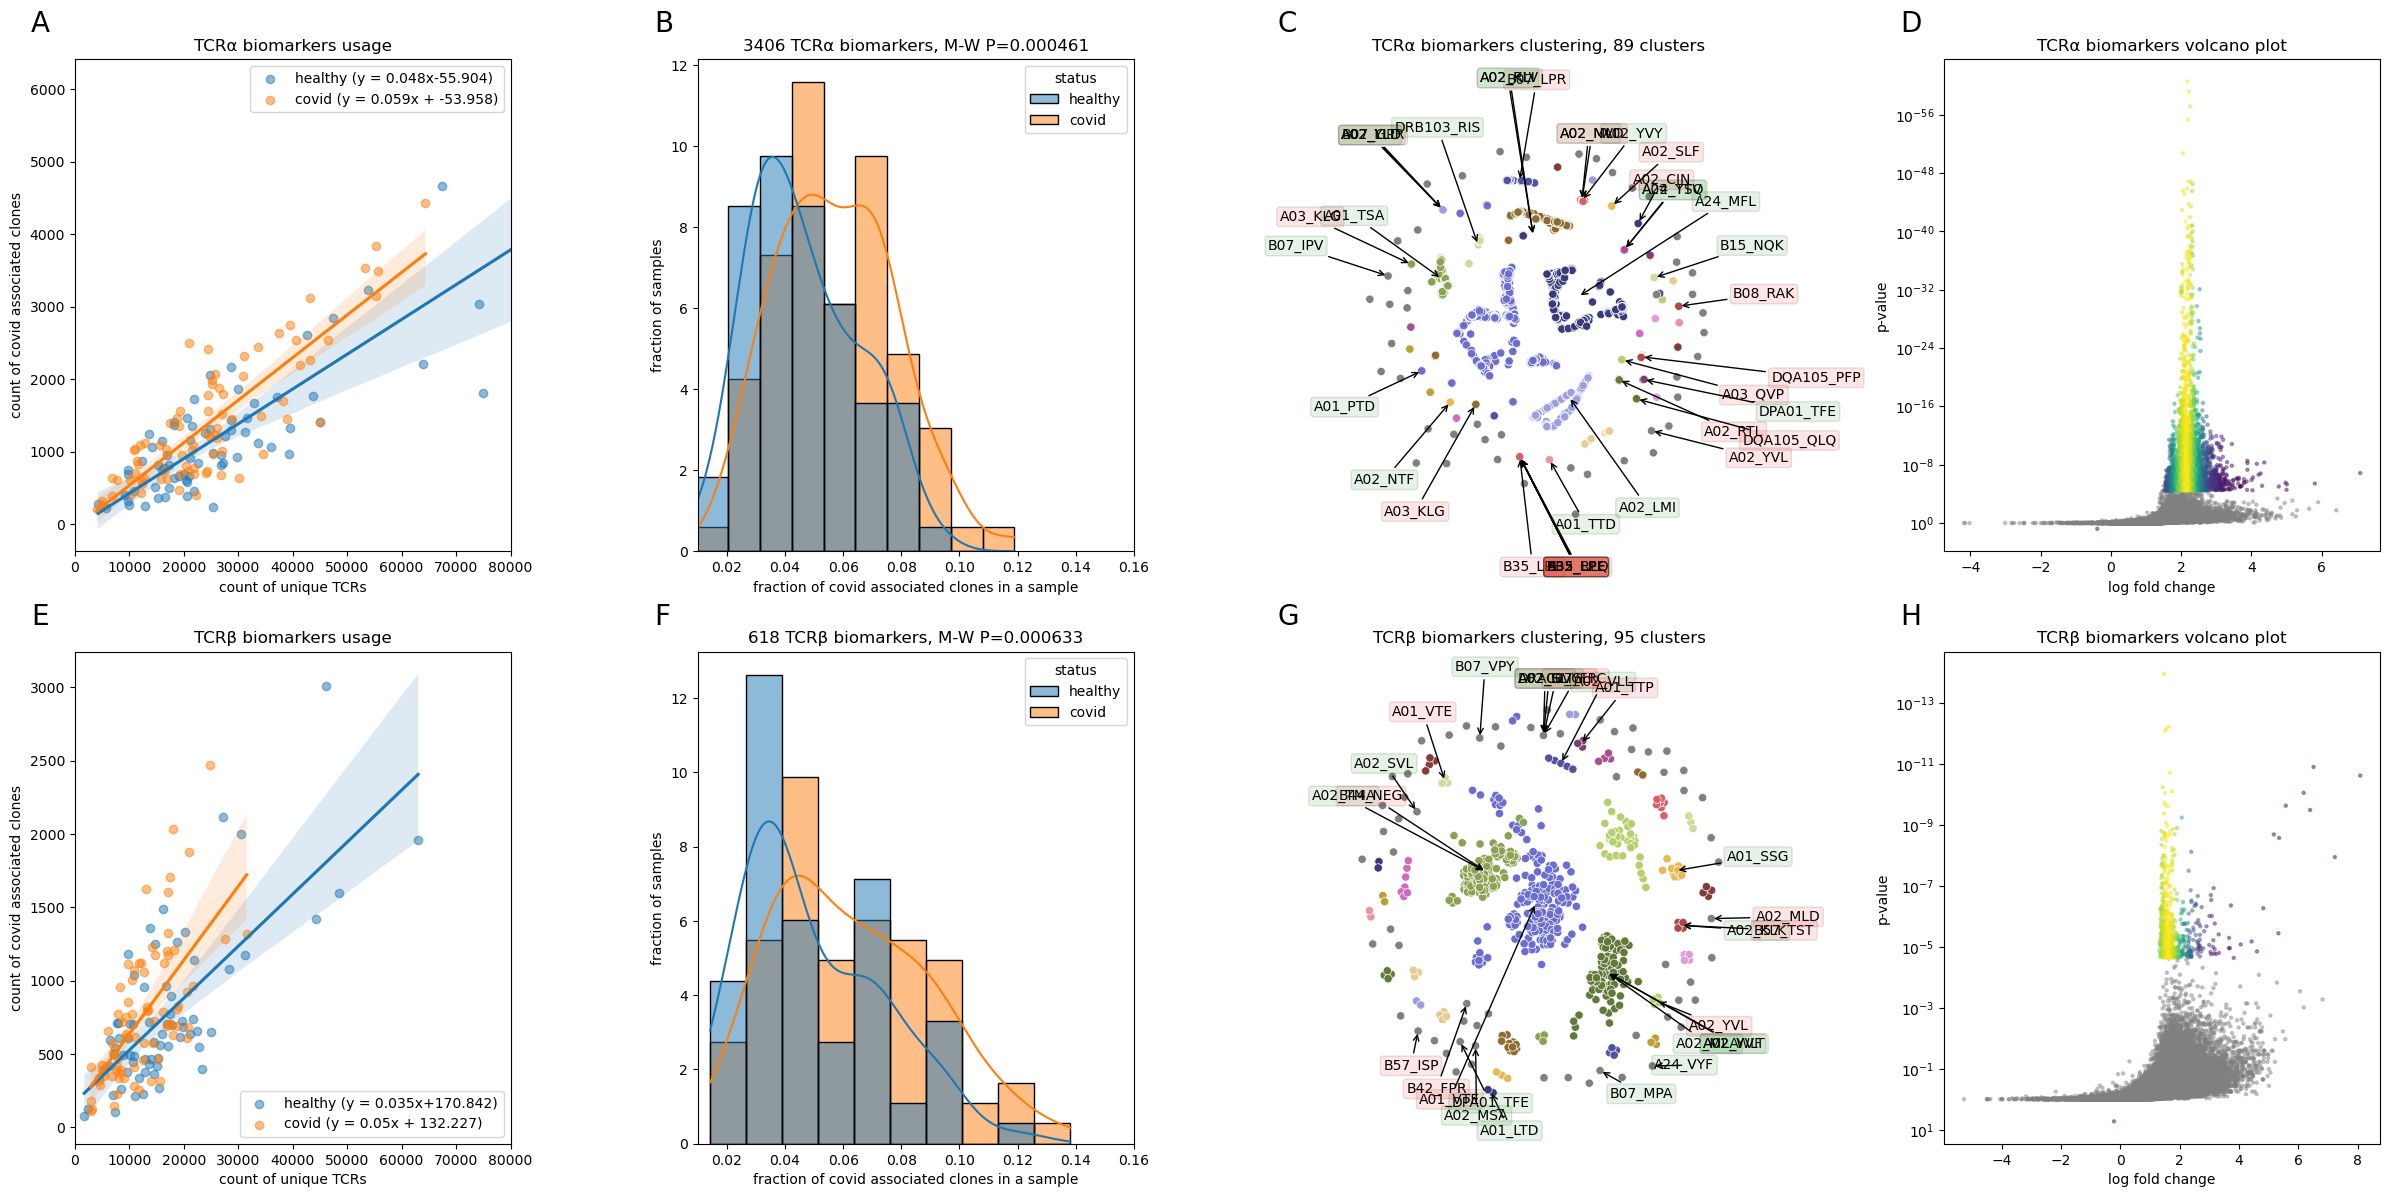

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
time = np.linspace(0, 10, 1000)
height = np.sin(time)
weight = time*0.3 + 2
score = time**2 + height
distribution = np.random.normal(0, 1, len(time))
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(nrows=2, 
              ncols=4)
font_size=20
delta_x=-0.1
delta_y=1.1

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax6 = fig.add_subplot(gs[0, 2])
ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_beta_cm[clean_beta_cm.run.isin(test_runs_beta)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc_beta, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

ax1.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_xlim(0.01, 0.16)
ax0.set_xlim(0, 80000)


beta_cluster_to_epi_abbr = plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=700, global_zero_based=True, ax=ax5)
ax5.set_xlim(-800, 800)
ax5.set_ylim(-800, 800)
ax5.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.legend().remove()
ax5.set_title(f'TCRβ biomarkers clustering, {res_beta.cluster.max() + 1} clusters')

####################################################

significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_alpha_cm[clean_alpha_cm.run.isin(test_runs_alpha)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc_alpha, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title(f'TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

ax3.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax3.set_xlim(0.01, 0.16)
ax2.set_xlim(0, 80000)


alpha_cluster_to_epi_abbr = plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=450, 
                                                center_diff_threshold=75,
                                                ax=ax6)
ax6.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.axis('off')
ax6.set_xlim(-500, 500)
ax6.set_ylim(-500, 600)
ax6.legend().remove()
ax6.set_title(f'TCRα biomarkers clustering, {res_alpha.cluster.max() + 1} clusters')
###################################################
ax6 = fig.add_subplot(gs[0, 3])

plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns, ax=ax6)
ax6.set_title('TCRα biomarkers volcano plot')
ax6.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

###################################################
ax7 = fig.add_subplot(gs[1, 3])

plot_volcano(fold_change_data_beta, selected_clones=clean_beta_cm.columns, ax=ax7)
ax7.set_title('TCRβ biomarkers volcano plot')
ax7.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################
plt.tight_layout()
plt.savefig("figures/supp_fig5.svg")
plt.savefig("figures/supp_fig5.pdf")
plt.savefig("figures/supp_fig5.png")
plt.show()

In [ ]:
df = fold_change_data_alpha[(fold_change_data_alpha['log_fold_change'] != np.inf) & (fold_change_data_alpha['log_fold_change'] > 1)]
df['logp'] = np.log10(df.pval)

In [ ]:
plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns)

In [ ]:
raw_beta_cm = prepare_run_column(raw_beta_cm)
raw_alpha_cm = prepare_run_column(raw_alpha_cm)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(16, 8))
gs = GridSpec(nrows=2, 
              ncols=4)
font_size=20
delta_x=-0.12
delta_y=1.1

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 0])
ax0 = fig.add_subplot(gs[0, 2])
ax1 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, 1])
significant_clones_distribution(significant_clonotype_matrix=raw_beta_cm[raw_beta_cm.run.isin(train_runs_beta)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc_beta, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

plot_olga_cleanup_data(probas_beta, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax4)
ax4.set_title('TCRβ biomarkers generation probability')
ax4.legend()
ax4.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

####################################################


significant_clones_distribution(significant_clonotype_matrix=raw_alpha_cm[raw_alpha_cm.run.isin(train_runs_alpha)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc_alpha, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)


plot_olga_cleanup_data(probas_alpha, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax5)
ax5.set_title('TCRα biomarkers generation probability')
ax5.legend()
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

###################################################
ax6 = fig.add_subplot(gs[1, 3])

plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns, ax=ax6)
ax6.set_title('TCRα biomarkers volcano plot')
ax6.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

###################################################
ax7 = fig.add_subplot(gs[1, 2])

plot_volcano(fold_change_data_beta, selected_clones=clean_beta_cm.columns, ax=ax7)
ax7.set_title('TCRβ biomarkers volcano plot')
ax7.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

plt.tight_layout()
plt.savefig("figures/supp_fig1.svg")
plt.savefig("figures/supp_fig1.pdf")
plt.savefig("figures/supp_fig1.png")
plt.show()

In [ ]:
def get_most_frequent_cluster_by_vdjdb_occurence(vdjdb, cluster_epitopes, gene):
    cluster_epitopes['cluster_epitopes_freq'] = cluster_epitopes.apply(lambda x: x['count'] / vdjdb[
        (vdjdb.gene == gene) & (vdjdb['antigen.epitope'] == x['antigen.epitope'])].cdr3.nunique(), axis=1)
    cluster_epitopes = cluster_epitopes.merge(vdjdb[['antigen.epitope', 'mhc.a']])
    return cluster_epitopes.sort_values(by='cluster_epitopes_freq', ascending=False).reset_index(drop=True).loc[0, :]

def get_most_probable_antigen(x, cluster_to_epi, gene):
    if cluster_to_epi[x] is None or len(cluster_to_epi[x]) == 0:
        return '-', '-', 0, '-'
    df = cluster_to_epi[x]
    df = df[~df['antigen.species'].str.contains('apiens')]
    if len(df) == 0:
        return '-', '-', 0, '-'
    res = get_most_frequent_cluster_by_vdjdb_occurence(
        vdjdb, 
        df,
        gene=gene)
    return res[['antigen.epitope', 'antigen.species', 'count', 'mhc.a']]


def create_summary_stats_table(clustering_res, cluster_to_epi, cm, vdjdb, desc, gene='TRB'):
    summary = clustering_res[['cluster', 'cluster_size']].drop_duplicates()
    summary['antigen.epitope'] = summary.cluster.apply(lambda x:  get_most_probable_antigen(x, cluster_to_epi, gene)[0])
    summary['antigen.species'] = summary.cluster.apply(lambda x:  get_most_probable_antigen(x, cluster_to_epi, gene)[1])
    summary['num_epi_associated_clones'] = summary.cluster.apply(lambda x: get_most_probable_antigen(x, cluster_to_epi, gene)[2])
    summary['mhc_a'] = summary.cluster.apply(lambda x: get_most_probable_antigen(x, cluster_to_epi, gene)[3])
    summary['mhc_a'] = summary['mhc_a'].apply(lambda x: x.split(':')[0].split('-')[1])
    summary['fraction_epi_associated_clones'] = summary['num_epi_associated_clones'] / summary['cluster_size']

    train_runs = desc[~desc.is_test_run].run
    test_runs = desc[desc.is_test_run].run

    healthy_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    healthy_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    covid_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])
    covid_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])

    train_cm = cm[cm.run.isin(train_runs)]
    test_cm = cm[cm.run.isin(test_runs)]
    summary['num_samples_with_cluster_train'] = summary.cluster.apply(
        lambda x: (train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_healthy'] = summary.cluster.apply(
        lambda x: (healthy_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_covid'] = summary.cluster.apply(
        lambda x: (covid_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())

    summary['num_samples_with_cluster_test'] = summary.cluster.apply(
        lambda x: (test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_healthy'] = summary.cluster.apply(
        lambda x: (healthy_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_covid'] = summary.cluster.apply(
        lambda x: (covid_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    
    summary['fraction_samples_with_cluster_train'] = summary['num_samples_with_cluster_train'] / len(train_cm)
    summary['fraction_of_healthy_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_healthy'] / summary['num_samples_with_cluster_train']
    summary['fraction_of_covid_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_covid'] / summary['num_samples_with_cluster_train']
    
    summary['fraction_samples_with_cluster_test'] = summary['num_samples_with_cluster_test'] / len(test_cm)
    summary['fraction_of_healthy_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_healthy'] / summary['num_samples_with_cluster_test']
    summary['fraction_of_covid_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_covid'] / summary['num_samples_with_cluster_test']
    
    # summary.to_excel(f'figures/clustering_summary_{gene}.xlsx')
    summary.to_csv(f'figures/clustering_summary_{gene}.csv', index=False)
    return summary

In [ ]:
beta_summary = create_summary_stats_table(res_beta, beta_cluster_to_epi, clean_beta_cm, vdjdb, desc=desc_beta, gene='TRB')
beta_summary

In [ ]:
alpha_summary = create_summary_stats_table(res_alpha, alpha_cluster_to_epi, clean_alpha_cm, vdjdb, desc=desc_alpha, gene='TRA')
alpha_summary

In [ ]:
beta_summary[beta_summary['antigen.epitope'] != '-']

In [ ]:
alpha_summary[alpha_summary['antigen.epitope'] != '-']